In [1]:
import pandas as pd
import os
import numpy as np
import scipy as sp
import torch

In [2]:
from scipy.stats import uniform, norm
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

In [3]:
A = 1.2
b = -0.3
sigma = 0.2
N = 100

In [4]:
np.random.seed(0)
X = torch.from_numpy(uniform.rvs(size=N))
X.detach()
X = X.float()

In [5]:
e = torch.from_numpy(norm.rvs(loc=0, scale=sigma, size=N)).float()

In [6]:
y = A*X + b + e

In [7]:
y.detach()
y = y.float()

In [8]:
def sigma_to_rho(sigma):
    rho = torch.log(torch.exp(sigma) - 1)
    return rho

In [9]:
def rho_to_sigma(rho):
    sigma = torch.log(1 + torch.exp(rho))
    return sigma

In [10]:
def log_q_pdf(w, theta):
    (mu_A, mu_b, rho_A, rho_b) = theta 
    
    sigma_A = rho_to_sigma(rho_A)
    qA = torch.distributions.normal.Normal(mu_A, sigma_A)
    
    sigma_b = rho_to_sigma(rho_b)
    qb = torch.distributions.normal.Normal(mu_b, sigma_b)
    
    lp = qA.log_prob(w[0]) + qb.log_prob(w[1])
    return lp

In [11]:
def log_p_pdf(w):
    prior_mu_A = torch.tensor(0.0) 
    prior_sigma_A = torch.tensor(1.0)
    pA = torch.distributions.normal.Normal(prior_mu_A, prior_sigma_A)
    
    prior_mu_b = torch.tensor(0.0) 
    prior_sigma_b = torch.tensor(1.0)
    pb = torch.distributions.normal.Normal(prior_mu_b, prior_sigma_b)
    
    lp = pA.log_prob(w[0]) + pb.log_prob(w[1])
    return lp

In [12]:
def likelihood(y,X,w):
    A = w[0]
    b = w[1]
    
    y_pred = A*X + b
    lp = torch.distributions.normal.Normal(y_pred, 0.2).log_prob(y).sum()
    return lp

In [13]:
def f(w, theta):
    v = log_q_pdf(w, theta) - log_p_pdf(w) - likelihood(y,X,w)
    return v

In [14]:
mu_A = torch.tensor(0.0)
sigma_A = torch.tensor(0.1)
rho_A = sigma_to_rho(sigma_A)
mu_b = torch.tensor(0.0)
sigma_b = torch.tensor(0.1)
rho_b = sigma_to_rho(sigma_b)

theta = torch.tensor([mu_A, mu_b, rho_A, rho_b], requires_grad=True)

In [15]:
alpha = torch.tensor(10e-5)

In [16]:
for i in range(0,1000):
    lst_grad_mu = []
    lst_grad_rho = []
    lst_v = []
    for j in range(0,20):
        epsilon = torch.distributions.normal.Normal(torch.tensor(0.0) , torch.tensor(1.0)).sample(torch.Size([2,]))

        with torch.no_grad():
            w = theta[0:2].clone().detach() + torch.log(1 + torch.exp(theta[2:4].clone().detach()))*epsilon
        w.requires_grad = True

        v = f(w, theta)   
        v.backward()
        lst_v.append(v.data)
        v = torch.tensor([])

        with torch.no_grad():
            grad_mu = w.grad + theta.grad[0:2]
            grad_rho = w.grad*epsilon/(1 + torch.exp(-theta[2:4])) + -theta.grad[2:4]


        lst_grad_mu.append(grad_mu)
        lst_grad_rho.append(grad_rho)

        theta.grad.zero_()
        w.grad.zero_()
        v.detach()
    grad_mu = torch.stack(lst_grad_mu).mean(dim=0)
    grad_rho = torch.stack(lst_grad_rho).mean(dim=0)
    
    print(torch.stack(lst_v).mean())
    #print(grad_mu)
    #print(grad_rho)
        
    with torch.no_grad():
        theta[0:2] -= alpha*grad_mu
        theta[2:4] -= alpha*grad_rho
    
    print(theta)



tensor(257.8456)
tensor([ 0.0604,  0.0770, -2.2509, -2.2559], requires_grad=True)
tensor(174.7455)
tensor([ 0.1064,  0.1265, -2.2501, -2.2590], requires_grad=True)
tensor(133.9840)
tensor([ 0.1440,  0.1587, -2.2504, -2.2601], requires_grad=True)
tensor(120.2917)
tensor([ 0.1743,  0.1770, -2.2511, -2.2622], requires_grad=True)
tensor(122.4848)
tensor([ 0.2027,  0.1900, -2.2536, -2.2637], requires_grad=True)
tensor(99.8990)
tensor([ 0.2300,  0.2051, -2.2538, -2.2663], requires_grad=True)
tensor(91.8073)
tensor([ 0.2476,  0.2021, -2.2537, -2.2692], requires_grad=True)
tensor(103.6791)
tensor([ 0.2720,  0.2123, -2.2545, -2.2735], requires_grad=True)
tensor(95.5194)
tensor([ 0.2854,  0.1999, -2.2555, -2.2763], requires_grad=True)
tensor(82.5183)
tensor([ 0.2978,  0.1867, -2.2561, -2.2779], requires_grad=True)
tensor(75.1287)
tensor([ 0.3097,  0.1746, -2.2561, -2.2798], requires_grad=True)
tensor(88.0406)
tensor([ 0.3230,  0.1631, -2.2572, -2.2825], requires_grad=True)
tensor(83.7382)
tensor

tensor(-4.5083)
tensor([ 1.0222, -0.1570, -2.3150, -2.4465], requires_grad=True)
tensor(-5.4477)
tensor([ 1.0231, -0.1630, -2.3152, -2.4472], requires_grad=True)
tensor(-2.5772)
tensor([ 1.0240, -0.1691, -2.3157, -2.4483], requires_grad=True)
tensor(11.2607)
tensor([ 1.0303, -0.1640, -2.3169, -2.4512], requires_grad=True)
tensor(1.0225)
tensor([ 1.0315, -0.1682, -2.3175, -2.4529], requires_grad=True)
tensor(4.4928)
tensor([ 1.0279, -0.1815, -2.3182, -2.4551], requires_grad=True)
tensor(1.6875)
tensor([ 1.0297, -0.1850, -2.3189, -2.4569], requires_grad=True)
tensor(-2.5739)
tensor([ 1.0339, -0.1833, -2.3192, -2.4582], requires_grad=True)
tensor(-1.6721)
tensor([ 1.0356, -0.1848, -2.3197, -2.4597], requires_grad=True)
tensor(1.7249)
tensor([ 1.0403, -0.1818, -2.3206, -2.4614], requires_grad=True)
tensor(2.3557)
tensor([ 1.0385, -0.1908, -2.3215, -2.4631], requires_grad=True)
tensor(2.0340)
tensor([ 1.0428, -0.1894, -2.3223, -2.4649], requires_grad=True)
tensor(-0.6035)
tensor([ 1.0471, -

tensor(-7.2656)
tensor([ 1.1511, -0.2464, -2.3704, -2.5903], requires_grad=True)
tensor(-6.9768)
tensor([ 1.1556, -0.2388, -2.3707, -2.5913], requires_grad=True)
tensor(-4.0230)
tensor([ 1.1574, -0.2366, -2.3714, -2.5924], requires_grad=True)
tensor(-2.5611)
tensor([ 1.1544, -0.2446, -2.3719, -2.5939], requires_grad=True)
tensor(-5.5029)
tensor([ 1.1571, -0.2398, -2.3722, -2.5952], requires_grad=True)
tensor(-6.0507)
tensor([ 1.1568, -0.2414, -2.3727, -2.5961], requires_grad=True)
tensor(-7.9538)
tensor([ 1.1585, -0.2391, -2.3731, -2.5967], requires_grad=True)
tensor(-1.1139)
tensor([ 1.1560, -0.2448, -2.3737, -2.5985], requires_grad=True)
tensor(-2.7646)
tensor([ 1.1581, -0.2422, -2.3742, -2.6001], requires_grad=True)
tensor(-3.1766)
tensor([ 1.1556, -0.2457, -2.3747, -2.6016], requires_grad=True)
tensor(-7.3876)
tensor([ 1.1581, -0.2420, -2.3750, -2.6024], requires_grad=True)
tensor(-5.3249)
tensor([ 1.1608, -0.2382, -2.3757, -2.6033], requires_grad=True)
tensor(-1.8480)
tensor([ 1.1

tensor(-9.1259)
tensor([ 1.1743, -0.2548, -2.4153, -2.6967], requires_grad=True)
tensor(-8.1420)
tensor([ 1.1708, -0.2612, -2.4159, -2.6972], requires_grad=True)
tensor(-7.2338)
tensor([ 1.1682, -0.2658, -2.4162, -2.6982], requires_grad=True)
tensor(-5.7205)
tensor([ 1.1717, -0.2585, -2.4168, -2.6990], requires_grad=True)
tensor(-9.0292)
tensor([ 1.1726, -0.2570, -2.4170, -2.6997], requires_grad=True)
tensor(-3.8079)
tensor([ 1.1696, -0.2629, -2.4175, -2.7010], requires_grad=True)
tensor(-6.0914)
tensor([ 1.1721, -0.2583, -2.4178, -2.7021], requires_grad=True)
tensor(-9.5571)
tensor([ 1.1721, -0.2587, -2.4181, -2.7027], requires_grad=True)
tensor(-8.5398)
tensor([ 1.1730, -0.2558, -2.4184, -2.7033], requires_grad=True)
tensor(-8.2708)
tensor([ 1.1759, -0.2505, -2.4187, -2.7040], requires_grad=True)
tensor(-5.3519)
tensor([ 1.1757, -0.2518, -2.4192, -2.7051], requires_grad=True)
tensor(-8.3785)
tensor([ 1.1759, -0.2526, -2.4196, -2.7057], requires_grad=True)
tensor(-7.4873)
tensor([ 1.1

tensor(-8.7404)
tensor([ 1.1854, -0.2436, -2.4596, -2.7848], requires_grad=True)
tensor(-9.1164)
tensor([ 1.1869, -0.2407, -2.4599, -2.7854], requires_grad=True)
tensor(-2.9738)
tensor([ 1.1853, -0.2450, -2.4603, -2.7867], requires_grad=True)
tensor(-9.1819)
tensor([ 1.1818, -0.2519, -2.4606, -2.7872], requires_grad=True)
tensor(-9.4762)
tensor([ 1.1794, -0.2566, -2.4608, -2.7878], requires_grad=True)
tensor(-8.5564)
tensor([ 1.1832, -0.2502, -2.4612, -2.7883], requires_grad=True)
tensor(-6.1340)
tensor([ 1.1806, -0.2550, -2.4618, -2.7892], requires_grad=True)
tensor(-3.7995)
tensor([ 1.1823, -0.2514, -2.4625, -2.7902], requires_grad=True)
tensor(-9.7802)
tensor([ 1.1819, -0.2520, -2.4627, -2.7907], requires_grad=True)
tensor(-6.2106)
tensor([ 1.1757, -0.2636, -2.4632, -2.7916], requires_grad=True)
tensor(-6.5946)
tensor([ 1.1780, -0.2591, -2.4637, -2.7923], requires_grad=True)
tensor(-8.6305)
tensor([ 1.1799, -0.2553, -2.4639, -2.7930], requires_grad=True)
tensor(-7.3532)
tensor([ 1.1

tensor(-8.7558)
tensor([ 1.1831, -0.2488, -2.4995, -2.8626], requires_grad=True)
tensor(-10.0606)
tensor([ 1.1851, -0.2454, -2.4997, -2.8631], requires_grad=True)
tensor(-9.1496)
tensor([ 1.1834, -0.2487, -2.5000, -2.8636], requires_grad=True)
tensor(-6.9075)
tensor([ 1.1902, -0.2370, -2.5005, -2.8643], requires_grad=True)
tensor(-6.3758)
tensor([ 1.1861, -0.2456, -2.5008, -2.8651], requires_grad=True)
tensor(-7.9168)
tensor([ 1.1843, -0.2496, -2.5011, -2.8658], requires_grad=True)
tensor(-8.0678)
tensor([ 1.1820, -0.2544, -2.5015, -2.8665], requires_grad=True)
tensor(-9.0198)
tensor([ 1.1837, -0.2503, -2.5017, -2.8671], requires_grad=True)
tensor(-7.6767)
tensor([ 1.1818, -0.2537, -2.5021, -2.8678], requires_grad=True)
tensor(-6.3949)
tensor([ 1.1810, -0.2549, -2.5024, -2.8688], requires_grad=True)
tensor(-8.7993)
tensor([ 1.1796, -0.2580, -2.5028, -2.8693], requires_grad=True)
tensor(-5.8552)
tensor([ 1.1791, -0.2592, -2.5035, -2.8701], requires_grad=True)
tensor(-8.0649)
tensor([ 1.

tensor(-6.3644)
tensor([ 1.1831, -0.2475, -2.5346, -2.9265], requires_grad=True)
tensor(-10.0529)
tensor([ 1.1808, -0.2517, -2.5348, -2.9269], requires_grad=True)
tensor(-9.8665)
tensor([ 1.1811, -0.2501, -2.5351, -2.9273], requires_grad=True)
tensor(-6.8747)
tensor([ 1.1811, -0.2504, -2.5354, -2.9282], requires_grad=True)
tensor(-9.9684)
tensor([ 1.1856, -0.2423, -2.5357, -2.9285], requires_grad=True)
tensor(-10.5398)
tensor([ 1.1864, -0.2407, -2.5359, -2.9289], requires_grad=True)
tensor(-10.0006)
tensor([ 1.1841, -0.2452, -2.5362, -2.9292], requires_grad=True)
tensor(-9.4798)
tensor([ 1.1830, -0.2470, -2.5365, -2.9296], requires_grad=True)
tensor(-8.6320)
tensor([ 1.1826, -0.2476, -2.5368, -2.9302], requires_grad=True)
tensor(-6.1780)
tensor([ 1.1792, -0.2553, -2.5372, -2.9310], requires_grad=True)
tensor(-7.4769)
tensor([ 1.1785, -0.2570, -2.5376, -2.9317], requires_grad=True)
tensor(-5.7961)
tensor([ 1.1791, -0.2561, -2.5381, -2.9326], requires_grad=True)
tensor(-8.3772)
tensor([ 

tensor(-11.2083)
tensor([ 1.1790, -0.2553, -2.5675, -2.9829], requires_grad=True)
tensor(-8.9113)
tensor([ 1.1812, -0.2514, -2.5677, -2.9834], requires_grad=True)
tensor(-10.2783)
tensor([ 1.1821, -0.2491, -2.5680, -2.9838], requires_grad=True)
tensor(-9.1574)
tensor([ 1.1807, -0.2515, -2.5683, -2.9842], requires_grad=True)
tensor(-8.3392)
tensor([ 1.1762, -0.2599, -2.5686, -2.9848], requires_grad=True)
tensor(-10.2244)
tensor([ 1.1781, -0.2569, -2.5689, -2.9850], requires_grad=True)
tensor(-6.7624)
tensor([ 1.1804, -0.2523, -2.5693, -2.9858], requires_grad=True)
tensor(-9.6001)
tensor([ 1.1834, -0.2466, -2.5696, -2.9862], requires_grad=True)
tensor(-9.5135)
tensor([ 1.1798, -0.2522, -2.5699, -2.9865], requires_grad=True)
tensor(-6.9538)
tensor([ 1.1793, -0.2523, -2.5704, -2.9872], requires_grad=True)
tensor(-8.9569)
tensor([ 1.1774, -0.2558, -2.5709, -2.9876], requires_grad=True)
tensor(-6.1473)
tensor([ 1.1805, -0.2483, -2.5713, -2.9884], requires_grad=True)
tensor(-9.7554)
tensor([ 

tensor(-8.7508)
tensor([ 1.1799, -0.2531, -2.5976, -3.0319], requires_grad=True)
tensor(-8.3456)
tensor([ 1.1824, -0.2486, -2.5980, -3.0324], requires_grad=True)
tensor(-10.6947)
tensor([ 1.1797, -0.2531, -2.5982, -3.0326], requires_grad=True)
tensor(-9.5877)
tensor([ 1.1778, -0.2561, -2.5985, -3.0330], requires_grad=True)
tensor(-10.4908)
tensor([ 1.1770, -0.2568, -2.5987, -3.0333], requires_grad=True)
tensor(-8.8791)
tensor([ 1.1795, -0.2531, -2.5991, -3.0336], requires_grad=True)
tensor(-8.2268)
tensor([ 1.1788, -0.2541, -2.5995, -3.0341], requires_grad=True)
tensor(-9.2163)
tensor([ 1.1804, -0.2518, -2.5999, -3.0345], requires_grad=True)
tensor(-8.2048)
tensor([ 1.1813, -0.2505, -2.6003, -3.0350], requires_grad=True)
tensor(-9.1149)
tensor([ 1.1831, -0.2476, -2.6007, -3.0354], requires_grad=True)
tensor(-9.1539)
tensor([ 1.1825, -0.2491, -2.6010, -3.0358], requires_grad=True)
tensor(-7.8111)
tensor([ 1.1780, -0.2575, -2.6015, -3.0364], requires_grad=True)
tensor(-9.4003)
tensor([ 1

tensor(-7.7890)
tensor([ 1.1782, -0.2545, -2.6268, -3.0744], requires_grad=True)
tensor(-9.6650)
tensor([ 1.1771, -0.2568, -2.6271, -3.0748], requires_grad=True)
tensor(-8.6169)
tensor([ 1.1797, -0.2519, -2.6275, -3.0751], requires_grad=True)
tensor(-10.9406)
tensor([ 1.1801, -0.2499, -2.6277, -3.0754], requires_grad=True)
tensor(-9.3882)
tensor([ 1.1810, -0.2479, -2.6280, -3.0757], requires_grad=True)
tensor(-8.9454)
tensor([ 1.1806, -0.2491, -2.6283, -3.0761], requires_grad=True)
tensor(-10.1762)
tensor([ 1.1801, -0.2497, -2.6286, -3.0765], requires_grad=True)
tensor(-8.7443)
tensor([ 1.1806, -0.2484, -2.6289, -3.0770], requires_grad=True)
tensor(-9.8868)
tensor([ 1.1794, -0.2506, -2.6292, -3.0773], requires_grad=True)
tensor(-8.7500)
tensor([ 1.1827, -0.2450, -2.6295, -3.0778], requires_grad=True)
tensor(-10.5540)
tensor([ 1.1803, -0.2500, -2.6297, -3.0780], requires_grad=True)
tensor(-8.8313)
tensor([ 1.1782, -0.2544, -2.6301, -3.0785], requires_grad=True)
tensor(-9.3634)
tensor([ 

In [17]:
lst_w = []
for j in range(0,2000):
    epsilon = torch.distributions.normal.Normal(torch.tensor(0.0) , torch.tensor(1.0)).sample(torch.Size([2,]))

    with torch.no_grad():
        w = theta[0:2].clone().detach() + torch.log(1 + torch.exp(theta[2:4].clone().detach()))*epsilon
    w.requires_grad = True
    
    lst_w.append(w)

In [18]:
X_test = np.linspace(0.0, 1.0, num=50)

<IPython.core.display.Javascript object>


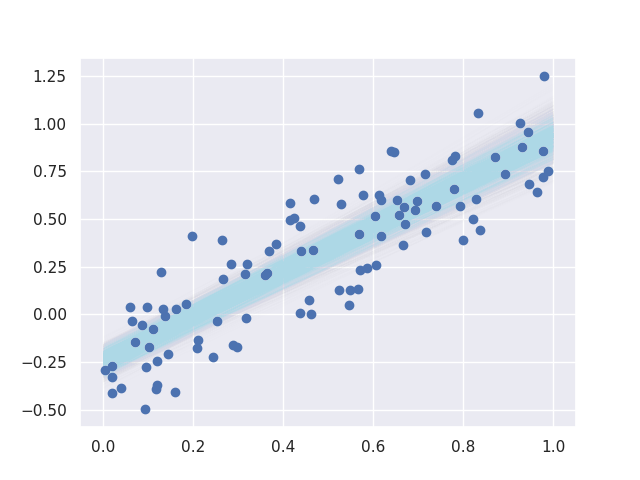

In [19]:
%matplotlib notebook
plt.scatter(X,y)
for w in lst_w:
    y_test = w.data[0].numpy()*X_test + w.data[1].numpy()
    plt.plot(X_test, y_test, alpha=0.005, linewidth=1, color='lightblue')

<IPython.core.display.Javascript object>


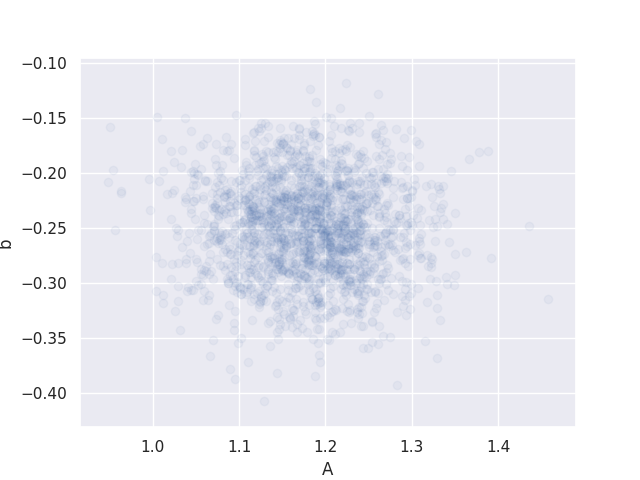

Text(0.5, 0, 'A')

In [20]:
%matplotlib notebook
W = torch.stack(lst_w)
plt.scatter(W[:,0].data, W[:,1].data,alpha=0.05)
plt.ylabel('b')
plt.xlabel('A')